In [ ]:
# # # Code to convert this notebook to .py if you want to run it via command line or with Slurm
# from subprocess import call
# command = "jupyter nbconvert Train.ipynb --to python"
# call(command,shell=True)

# Import packages & functions

In [1]:
import os
import sys
import json
import argparse
import numpy as np
import math
from einops import rearrange
import time
import random
import string
import h5py
from tqdm import tqdm
from IPython.display import display, Image

import webdataset as wds
import gc

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchvision import transforms

from accelerate import Accelerator, DeepSpeedPlugin

# tf32 data type is faster than standard float32
torch.backends.cuda.matmul.allow_tf32 = True
from clip_retrieval.clip_client import ClipClient, Modality

# custom functions #
import utils

In [2]:
### Multi-GPU config ###
local_rank = os.getenv('RANK')
if local_rank is None: 
    local_rank = 0
else:
    local_rank = int(local_rank)
print("LOCAL RANK ", local_rank)  

num_devices = torch.cuda.device_count()
if num_devices==0: num_devices = 1

# ## UNCOMMENT BELOW SECTION AND COMMENT OUT DEEPSPEED SECTION TO AVOID USING DEEPSPEED ###
accelerator = Accelerator(split_batches=False, mixed_precision="fp16")
global_batch_size = batch_size = 128
data_type = torch.float16 # change depending on your mixed_precision

### DEEPSPEED INITIALIZATION ###
# if utils.is_interactive():
#     global_batch_size = batch_size = 128
#     print(f"Setting batch_size to {batch_size}")
#     # can emulate a distributed environment for deepspeed to work in jupyter notebook
#     os.environ["MASTER_ADDR"] = "localhost"
#     os.environ["MASTER_PORT"] = str(np.random.randint(10000)+9000)
#     os.environ["RANK"] = "0"
#     os.environ["LOCAL_RANK"] = "0"
#     os.environ["WORLD_SIZE"] = "1"
#     os.environ["GLOBAL_BATCH_SIZE"] = str(global_batch_size) # set this to your batch size!
# else:
#     global_batch_size = os.environ["GLOBAL_BATCH_SIZE"]    
#     batch_size = int(os.environ["GLOBAL_BATCH_SIZE"]) // num_devices

# # alter the deepspeed config according to your global and local batch size
# if local_rank == 0:
#     with open('deepspeed_config_stage2.json', 'r') as file:
#         config = json.load(file)
#     config['train_batch_size'] = int(os.environ["GLOBAL_BATCH_SIZE"])
#     config['train_micro_batch_size_per_gpu'] = batch_size
#     config['bf16'] = {'enabled': False}
#     config['fp16'] = {'enabled': True}
#     with open('deepspeed_config_stage2.json', 'w') as file:
#         json.dump(config, file)
# else:
#     # give some time for the local_rank=0 gpu to prep new deepspeed config file
#     time.sleep(10)
# deepspeed_plugin = DeepSpeedPlugin("deepspeed_config_stage2.json")
# # accelerator = Accelerator(split_batches=False)

LOCAL RANK  0


In [3]:
print("PID of this process =",os.getpid())
device = accelerator.device
print("device:",device)
num_workers = num_devices
print(accelerator.state)
world_size = accelerator.state.num_processes
distributed = not accelerator.state.distributed_type == 'NO'

# set data_type to match your mixed precision (automatically set based on deepspeed config)
if accelerator.mixed_precision == "bf16":
    data_type = torch.bfloat16
elif accelerator.mixed_precision == "fp16":
    data_type = torch.float16
else:
    data_type = torch.float32

print("distributed =",distributed, "num_devices =", num_devices, "local rank =", local_rank, "world size =", world_size, "data_type =", data_type)
print = accelerator.print # only print if local_rank=0

PID of this process = 3048541
device: cuda
Distributed environment: NO
Num processes: 1
Process index: 0
Local process index: 0
Device: cuda

Mixed precision type: fp16

distributed = False num_devices = 4 local rank = 0 world size = 1 data_type = torch.float16


# Configurations

In [4]:
# if running this interactively, can specify jupyter_args here for argparser to use
if utils.is_interactive():
    # create random model_name
    model_name = ''.join(random.choices(string.ascii_letters + string.digits, k=10))
    model_name = model_name + "_interactive"
    print("model_name:", model_name)

    # global_batch_size and batch_size should already be defined in the above cells
    jupyter_args = f"--data_path=/fsx/proj-fmri/shared/mindeyev2_dataset \
                    --model_name={model_name} \
                    --subj=1 --batch_size={batch_size} --blurry_recon --no-depth_recon \
                    --clip_scale=1. --blur_scale=100. --depth_scale=100. \
                    --max_lr=3e-4 --mixup_pct=.66 --num_epochs=12 --ckpt_interval=999 --no-use_image_aug --no-ckpt_saving"

    jupyter_args = jupyter_args.split()#other variables can be specified in the following string:
    
    print(jupyter_args)
    
    from IPython.display import clear_output # function to clear print outputs in cell
    %load_ext autoreload 
    # this allows you to change functions in models.py or utils.py and have this notebook automatically update with your revisions
    %autoreload 2 

model_name: np7cryqEIM_interactive
['--data_path=/fsx/proj-fmri/shared/mindeyev2_dataset', '--model_name=np7cryqEIM_interactive', '--subj=1', '--batch_size=128', '--blurry_recon', '--no-depth_recon', '--clip_scale=1.', '--blur_scale=100.', '--depth_scale=100.', '--max_lr=3e-4', '--mixup_pct=.66', '--num_epochs=12', '--ckpt_interval=999', '--no-use_image_aug', '--no-ckpt_saving']


In [25]:
args.use_image_aug

False

In [5]:
parser = argparse.ArgumentParser(description="Model Training Configuration")
parser.add_argument(
    "--model_name", type=str, default="testing",
    help="name of model, used for ckpt saving and wandb logging (if enabled)",
)
parser.add_argument(
    "--data_path", type=str, default="/fsx/proj-fmri/shared/natural-scenes-dataset",
    help="Path to where NSD data is stored / where to download it to",
)
parser.add_argument(
    "--subj",type=int, default=1, choices=[1,2,5,7],
)
parser.add_argument(
    "--batch_size", type=int, default=32,
    help="Batch size can be increased by 10x if only training v2c and not diffusion diffuser",
)
parser.add_argument(
    "--wandb_log",action=argparse.BooleanOptionalAction,default=False,
    help="whether to log to wandb",
)
parser.add_argument(
    "--resume_from_ckpt",action=argparse.BooleanOptionalAction,default=False,
    help="if not using wandb and want to resume from a ckpt",
)
parser.add_argument(
    "--wandb_project",type=str,default="stability",
    help="wandb project name",
)
parser.add_argument(
    "--mixup_pct",type=float,default=.33,
    help="proportion of way through training when to switch from BiMixCo to SoftCLIP",
)
parser.add_argument(
    "--blurry_recon",action=argparse.BooleanOptionalAction,default=True,
    help="whether to output blurry reconstructions",
)
parser.add_argument(
    "--depth_recon",action=argparse.BooleanOptionalAction,default=True,
    help="whether to output depth reconstructions",
)
parser.add_argument(
    "--blur_scale",type=float,default=100.,
    help="multiply loss from blurry recons by this number",
)
parser.add_argument(
    "--depth_scale",type=float,default=100.,
    help="multiply loss from depth recons by this number",
)
parser.add_argument(
    "--clip_scale",type=float,default=1.,
    help="multiply contrastive loss by this number",
)
parser.add_argument(
    "--use_image_aug",action=argparse.BooleanOptionalAction,default=True,
    help="whether to use image augmentation",
)
parser.add_argument(
    "--num_epochs",type=int,default=120,
    help="number of epochs of training",
)
parser.add_argument(
    "--lr_scheduler_type",type=str,default='cycle',choices=['cycle','linear'],
)
parser.add_argument(
    "--ckpt_saving",action=argparse.BooleanOptionalAction,default=True,
)
parser.add_argument(
    "--ckpt_interval",type=int,default=5,
    help="save backup ckpt and reconstruct every x epochs",
)
parser.add_argument(
    "--seed",type=int,default=42,
)
parser.add_argument(
    "--max_lr",type=float,default=3e-4,
)

if utils.is_interactive():
    args = parser.parse_args(jupyter_args)
else:
    args = parser.parse_args()

# create global variables without the args prefix
for attribute_name in vars(args).keys():
    globals()[attribute_name] = getattr(args, attribute_name)

In [26]:
args

Namespace(model_name='np7cryqEIM_interactive', data_path='/fsx/proj-fmri/shared/mindeyev2_dataset', subj=1, batch_size=128, wandb_log=False, resume_from_ckpt=False, wandb_project='stability', mixup_pct=0.66, blurry_recon=True, depth_recon=False, blur_scale=100.0, depth_scale=100.0, clip_scale=1.0, use_image_aug=False, num_epochs=12, lr_scheduler_type='cycle', ckpt_saving=False, ckpt_interval=999, seed=42, max_lr=0.0003)

In [6]:
outdir = os.path.abspath(f'../train_logs/{model_name}')
if not os.path.exists(outdir):
    os.makedirs(outdir,exist_ok=True)
if use_image_aug:
    import kornia
    from kornia.augmentation.container import AugmentationSequential
    img_augment = AugmentationSequential(
        kornia.augmentation.RandomResizedCrop((224,224), (0.6,1), p=0.3),
        kornia.augmentation.Resize((224, 224)),
        kornia.augmentation.RandomHorizontalFlip(p=0.3),
        kornia.augmentation.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.2, hue=0.1, p=0.3),
        kornia.augmentation.RandomGrayscale(p=0.3),
        same_on_batch=False,
        data_keys=["input"],
    )

# Prep data, models, and dataloaders

## Dataloader

In [7]:
if subj==1:
    num_train = 24958
    num_test = 2770
test_batch_size = num_test

def my_split_by_node(urls): return urls
    
train_url = f"{data_path}/wds/subj0{subj}/train/" + "{0..36}.tar"
print(train_url)

train_data = wds.WebDataset(train_url,resampled=False,nodesplitter=my_split_by_node)\
                    .shuffle(750, initial=1500, rng=random.Random(42))\
                    .decode("torch")\
                    .rename(behav="behav.npy", past_behav="past_behav.npy", future_behav="future_behav.npy", olds_behav="olds_behav.npy")\
                    .to_tuple(*["behav", "past_behav", "future_behav", "olds_behav"])
train_dl = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=False, drop_last=True, pin_memory=True)

test_url = f"{data_path}/wds/subj0{subj}/test/" + "0.tar"
print(test_url)

test_data = wds.WebDataset(test_url,resampled=False,nodesplitter=my_split_by_node)\
                    .shuffle(750, initial=1500, rng=random.Random(42))\
                    .decode("torch")\
                    .rename(behav="behav.npy", past_behav="past_behav.npy", future_behav="future_behav.npy", olds_behav="olds_behav.npy")\
                    .to_tuple(*["behav", "past_behav", "future_behav", "olds_behav"])
test_dl = torch.utils.data.DataLoader(test_data, batch_size=test_batch_size, shuffle=False, drop_last=True, pin_memory=True)

/fsx/proj-fmri/shared/mindeyev2_dataset/wds/subj01/train/{0..36}.tar
/fsx/proj-fmri/shared/mindeyev2_dataset/wds/subj01/test/0.tar


### check dataloaders are working

In [8]:
test_vox_indices = []
test_73k_images = []
for test_i, (behav, past_behav, future_behav, old_behav) in enumerate(test_dl):
    test_vox_indices = np.append(test_vox_indices, behav[:,0,5].cpu().numpy())
    test_73k_images = np.append(test_73k_images, behav[:,0,0].cpu().numpy())
test_vox_indices = test_vox_indices.astype(np.int16)
print(test_i, (test_i+1) * test_batch_size, len(test_vox_indices))
print("---\n")

train_vox_indices = []
train_73k_images = []
for train_i, (behav, past_behav, future_behav, old_behav) in enumerate(train_dl):
    train_vox_indices = np.append(train_vox_indices, behav[:,0,5].long().cpu().numpy())
    train_73k_images = np.append(train_73k_images, behav[:,0,0].cpu().numpy())
train_vox_indices = train_vox_indices.astype(np.int16)
print(train_i, (train_i+1) * batch_size, len(train_vox_indices))

all_vox_indices = np.hstack((train_vox_indices, test_vox_indices))
all_images = np.hstack((train_73k_images, test_73k_images))

0 2770 2770
---

194 24960 24960


## Load data and images

In [9]:
# load betas
f = h5py.File(f'{data_path}/betas_all_subj0{subj}.hdf5', 'r')
# f = h5py.File(f'{data_path}/betas_subj0{subj}_thresholded_wholebrain.hdf5', 'r')

voxels = f['betas'][:]
print(f"subj0{subj} betas loaded into memory")
voxels = torch.Tensor(voxels).to("cpu").to(data_type)
print("voxels", voxels.shape)
num_voxels = voxels.shape[-1]

# load orig images
f = h5py.File(f'{data_path}/coco_images_224_float16.hdf5', 'r')
images = f['images'][:]
images = torch.Tensor(images).to("cpu").to(data_type)
print("images", images.shape)

subj01 betas loaded into memory
voxels torch.Size([27750, 15724])
images torch.Size([73000, 3, 224, 224])


## Load models

### CLIP image embeddings  model

In [10]:
# from models import Clipper
# clip_model = Clipper("ViT-L/14", device=torch.device(f"cuda:{local_rank}"), hidden_state=True, norm_embs=True)
device=torch.device(f"cuda:{local_rank}")
clip_seq_dim = 257
clip_emb_dim = 768 #1024
hidden_dim = 4096 #* 2

### SD VAE

In [11]:
# if blurry_recon:
#     from diffusers import AutoencoderKL
#     autoenc = AutoencoderKL.from_pretrained("madebyollin/sdxl-vae-fp16-fix", torch_dtype=torch.float16, cache_dir="/fsx/proj-fmri/shared/cache")
#     # autoenc.load_state_dict(torch.load('../train_logs/sdxl_vae_normed/best.pth')["model_state_dict"])
#     autoenc.eval()
#     autoenc.requires_grad_(False)
#     autoenc.to(device)
#     utils.count_params(autoenc)

if blurry_recon:
    from diffusers import VQModel
    autoenc = VQModel.from_pretrained("/fsx/proj-fmri/shared/cache/models--microsoft--vq-diffusion-ithq/snapshots/3f796fb49ee559370dc638dea1d8116af131d993/vqvae", torch_dtype=data_type)
    autoenc.eval()
    autoenc.requires_grad_(False)
    autoenc.to(device)
    utils.count_params(autoenc)

param counts:
64,009,667 total
0 trainable


#### downsampled images

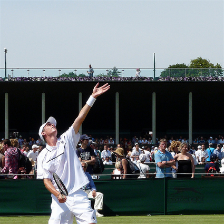

torch.Size([1, 3, 224, 224])
torch.Size([1, 128, 16, 16])


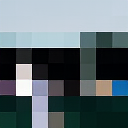

In [12]:
if blurry_recon:
    if utils.is_interactive(): display(utils.torch_to_Image(images[[30]]))

    input_batch = images[[30]].to(device)
    print(input_batch.shape)

    downsampled_image = nn.functional.interpolate(input_batch, size=(8, 8), mode='bilinear', align_corners=False)
    re_upsampled_image = nn.functional.interpolate(downsampled_image, size=(128, 128), mode='nearest')
    re_upsampled_enc = autoenc.encode(2*re_upsampled_image-1).latents * 0.18215
    print(re_upsampled_enc.shape)
    
    if utils.is_interactive(): display(utils.torch_to_Image((autoenc.decode(re_upsampled_enc/0.18215).sample / 2 + 0.5).clamp(0,1)))

#### MiDaS depth

In [13]:
if depth_recon:
    from controlnet_aux.midas import MidasDetector
    
    midas_depth = MidasDetector.from_pretrained(
      "valhalla/t2iadapter-aux-models", filename="dpt_large_384.pt", model_type="dpt_large", cache_dir="/fsx/proj-fmri/shared/cache").to(device)
    midas_depth.model.eval()
    midas_depth.model.requires_grad_(False)
    midas_depth.model.to(device)
    pass

In [14]:
if depth_recon:
    if utils.is_interactive(): display(utils.torch_to_Image(images[[30]]))

    input_batch = images[[30,31]].float().to(device)
    print(input_batch.shape)
    
    midas_emb = midas_depth.model(input_batch).unsqueeze(1)
    print(midas_emb.shape)

    prediction = utils.resize(midas_emb, 32) #/30).clamp(0,1).half() # 30 is roughly prediction.max()
    print(prediction.shape)
    
    prediction = (prediction / prediction.view(prediction.shape[0], -1).max(dim=1)[0].view(-1, 1, 1, 1).expand_as(prediction)).half()
    midas_emb_size = prediction.flatten(1).shape[1]
    print("midas_emb", prediction.shape, prediction.min(), prediction.max())
    print("midas_emb_size", midas_emb_size)
    
    if utils.is_interactive(): display(utils.torch_to_Image(utils.resize(prediction, 224))) 

    if blurry_recon:
        prediction = utils.resize(midas_emb, 128).half().repeat(1,3,1,1)
        prediction = (prediction / prediction.view(prediction.shape[0], -1).max(dim=1)[0].view(-1, 1, 1, 1).expand_as(prediction)).half()
        prediction_enc = autoenc.encode(2*prediction-1).latents * 0.18215
        print("vae midas_emb", prediction_enc.shape, prediction_enc.min(), prediction_enc.max())
    
        if utils.is_interactive(): display(utils.torch_to_Image((autoenc.decode(prediction_enc/0.18215).sample / 2 + 0.5).clamp(0,1)))

### MindEye modules

In [15]:
dev_dino = torch.device("cuda:2")
dinov2_model = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitg14').to(dev_dino)
def get_dinov2_embeds(dinov2, image):
    with torch.no_grad():
        image = image.to(dev_dino)
        dv2_embeds = dinov2.forward_features(image)["x_norm_patchtokens"]
        return dv2_embeds.to(device)

Using cache found in /admin/home-mihirneal/.cache/torch/hub/facebookresearch_dinov2_main
/admin/home-mihirneal/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:43: UserWarning: xFormers is available (SwiGLU)
  warnings.warn("xFormers is available (SwiGLU)")
/admin/home-mihirneal/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:27: UserWarning: xFormers is available (Attention)
  warnings.warn("xFormers is available (Attention)")
/admin/home-mihirneal/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:33: UserWarning: xFormers is available (Block)
  warnings.warn("xFormers is available (Block)")


In [16]:
class MindEyeModule(nn.Module):
    def __init__(self):
        super(MindEyeModule, self).__init__()
    def forward(self, x):
        return x
        
model = MindEyeModule()
model

MindEyeModule()

In [17]:
class RidgeRegression(torch.nn.Module):
    # make sure to add weight_decay when initializing optimizer
    def __init__(self, input_size, out_features): 
        super(RidgeRegression, self).__init__()
        self.out_features = out_features
        self.linear = torch.nn.Linear(input_size, out_features)
    def forward(self, x):
        return self.linear(x)
        
model.ridge = RidgeRegression(voxels.shape[1], out_features=hidden_dim)
utils.count_params(model.ridge)
utils.count_params(model)

b = torch.randn((2,1,voxels.shape[1]))
print(b.shape, model.ridge(b).shape)

param counts:
64,409,600 total
64,409,600 trainable
param counts:
64,409,600 total
64,409,600 trainable
torch.Size([2, 1, 15724]) torch.Size([2, 1, 4096])


In [18]:
from functools import partial
from diffusers.models.vae import Decoder
class BrainNetwork(nn.Module):
    def __init__(self, out_dim=768, in_dim=15724, clip_size=768, h=4096, n_blocks=4, norm_type='ln', act_first=False, drop=.15, blurry_dim=16):
        super().__init__()
        self.blurry_dim = blurry_dim
        norm_func = partial(nn.BatchNorm1d, num_features=h) if norm_type == 'bn' else partial(nn.LayerNorm, normalized_shape=h)
        act_fn = partial(nn.ReLU, inplace=True) if norm_type == 'bn' else nn.GELU
        act_and_norm = (act_fn, norm_func) if act_first else (norm_func, act_fn)
        self.lin0 = nn.Linear(in_dim, h)
        self.mlp = nn.ModuleList([
            nn.Sequential(
                nn.Linear(h, h),
                *[item() for item in act_and_norm],
                nn.Dropout(drop)
            ) for _ in range(n_blocks)
        ])

        if blurry_recon:
            # self.blin1 = nn.Sequential(
            #     nn.Linear(out_dim, 4096, bias=True),
            #     nn.LayerNorm(4096),
            #     nn.GELU(),
            #     nn.Linear(4096, 4096))
            self.blin1 = nn.Linear(h, 4096)
            self.bgroupnorm = nn.GroupNorm(1, 256)
            self.bupsampler = Decoder(
                in_channels=256,
                out_channels=128,
                up_block_types=["UpDecoderBlock2D","UpDecoderBlock2D","UpDecoderBlock2D"],
                block_out_channels=[32, 64, 128],
                layers_per_block=1,
            )

        if depth_recon:
            # self.dlin1 = nn.Sequential(
            #         nn.Linear(h, midas_emb_size),
            #         nn.Sigmoid(),
            #     )
            self.dlin1 = nn.Linear(h, 4096)
            self.dgroupnorm = nn.GroupNorm(1, 256)
            self.dupsampler = Decoder(
                in_channels=256,
                out_channels=1,#128,
                up_block_types=["UpDecoderBlock2D","UpDecoderBlock2D","UpDecoderBlock2D","UpDecoderBlock2D"],
                block_out_channels=[32, 64, 128, 256],
                layers_per_block=1,
            )
        
        self.n_blocks = n_blocks
        self.clip_size = clip_size
        self.clin1 = nn.Linear(h, out_dim, bias=True)

        # low-rank matrices
        # self.rank = 1000
        # self.U = nn.Parameter(torch.randn(self.rank, out_dim))
        # self.V = nn.Parameter(torch.randn(h, self.rank))
        
        self.clip_proj = nn.Sequential(
            nn.LayerNorm(clip_size),
            nn.GELU(),
            nn.Linear(clip_size, 2048),
            nn.LayerNorm(2048),
            nn.GELU(),
            nn.Linear(2048, 2048),
            nn.LayerNorm(2048),
            nn.GELU(),
            nn.Linear(2048, clip_size)
        )
        
    def forward(self, x):
        b, d = torch.Tensor([0.]), torch.Tensor([0.])
        data_type = x.dtype
        x = self.lin0(x)
        residual = x
        for res_block in range(self.n_blocks):
            x = self.mlp[res_block](x)
            x += residual
            residual = x
        x = x.reshape(len(x), -1)

        # linear mapping to out_dim
        c = self.clin1(x)

        # low rank linear to out dim cuts # params by nearly half compared to full linear mapping
        # c = x @ (self.V/100) @ (self.U/100)
        y = c.reshape(len(c), -1, self.clip_size)
        c = self.clip_proj(y)
        if blurry_recon:
            b = self.blin1(x)
            b = b.reshape(len(b), 256, 4, 4)
            b = self.bgroupnorm(b)
            b = self.bupsampler(b)
            
        if depth_recon:
            d = self.dlin1(x)#.reshape(len(x), 1, 32, 32)

            d = d.reshape(len(d), 256, 4, 4)
            d = self.dgroupnorm(d)
            d = self.dupsampler(d)
            
        return c, b, d

model.backbone = BrainNetwork(h=hidden_dim, in_dim=hidden_dim, clip_size=768, out_dim=768*257, blurry_dim=64*7*7) 
utils.count_params(model.backbone)
utils.count_params(model)

# test that the model works on some fake data
b = torch.randn((2,hidden_dim))
print("b.shape",b.shape)
clip_, blur_, depth_ = model.backbone(b)
print(clip_.shape, blur_.shape, depth_.shape)

param counts:
1,724,237,472 total
1,724,237,472 trainable
param counts:
1,788,647,072 total
1,788,647,072 trainable
b.shape torch.Size([2, 4096])
torch.Size([2, 256, 1536]) torch.Size([2, 128, 16, 16]) torch.Size([1])


In [19]:
no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
opt_grouped_parameters = [
    {'params': [p for n, p in model.ridge.named_parameters()], 'weight_decay': 1e-2},
    {'params': [p for n, p in model.backbone.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 1e-2},
    {'params': [p for n, p in model.backbone.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0},
]

optimizer = torch.optim.AdamW(opt_grouped_parameters, lr=max_lr)

if lr_scheduler_type == 'linear':
    lr_scheduler = torch.optim.lr_scheduler.LinearLR(
        optimizer,
        total_iters=int(np.floor(num_epochs*(num_train/num_devices/batch_size))),
        last_epoch=-1
    )
elif lr_scheduler_type == 'cycle':
    total_steps=int(np.floor(num_epochs*(num_train/num_devices/batch_size)))
    print("total_steps", total_steps)
    lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer, 
        max_lr=max_lr,
        total_steps=total_steps,
        final_div_factor=1000,
        last_epoch=-1, pct_start=2/num_epochs
    )
    
def save_ckpt(tag):    
    ckpt_path = outdir+f'/{tag}.pth'
    print(f'saving {ckpt_path}',flush=True)
    unwrapped_model = accelerator.unwrap_model(model)
    try:
        torch.save({
            'epoch': epoch,
            'model_state_dict': unwrapped_model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'lr_scheduler': lr_scheduler.state_dict(),
            'train_losses': losses,
            'test_losses': test_losses,
            'lrs': lrs,
            }, ckpt_path)
    except:
        print("Couldn't save... moving on to prevent crashing.")
    del unwrapped_model
        
print("\nDone with model preparations!")
utils.count_params(model)

total_steps 584

Done with model preparations!
param counts:
1,788,647,072 total
1,788,647,072 trainable


# Weights and Biases

In [20]:
if local_rank==0 and wandb_log: # only use main process for wandb logging
    import wandb
    wandb_project = 'mindeyev2'
    wandb_run = model_name
    wandb_notes = ''
    
    print(f"wandb {wandb_project} run {wandb_run}")
    wandb.login(host='https://stability.wandb.io')#, relogin=True)
    wandb_config = {
      "model_name": model_name,
      "global_batch_size": global_batch_size,
      "batch_size": batch_size,
      "num_epochs": num_epochs,
      "clip_scale": clip_scale,
      "blur_scale": blur_scale,
      "use_image_aug": use_image_aug,
      "max_lr": max_lr,
      "mixup_pct": mixup_pct,
      "num_train": num_train,
      "num_test": num_test,
      "ckpt_interval": ckpt_interval,
      "ckpt_saving": ckpt_saving,
      "seed": seed,
      "distributed": distributed,
      "num_devices": num_devices,
      "world_size": world_size,
      "train_url": train_url,
      "test_url": test_url,
    }
    print("wandb_config:\n",wandb_config)
    if True: # wandb_auto_resume
        print("wandb_id:",model_name)
        wandb.init(
            id = model_name,
            project=wandb_project,
            name=wandb_run,
            config=wandb_config,
            notes=wandb_notes,
            resume="allow",
        )
    else:
        wandb.init(
            project=wandb_project,
            name=wandb_run,
            config=wandb_config,
            notes=wandb_notes,
        )
else:
    wandb_log = False

# Main

In [21]:
epoch = 0
losses, test_losses, lrs = [], [], []
best_test_loss = 1e9
soft_loss_temps = utils.cosine_anneal(0.004, 0.0075, num_epochs - int(mixup_pct * num_epochs))

# Optionally resume from checkpoint #
if resume_from_ckpt:
    print("\n---resuming from last.pth ckpt---\n")
    try:
        checkpoint = torch.load(outdir+'/last.pth', map_location='cpu')
    except:
        print('last.pth failed... trying last_backup.pth')
        checkpoint = torch.load(outdir+'/last_backup.pth', map_location='cpu')
    epoch = checkpoint['epoch']
    print("Epoch",epoch)
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    lr_scheduler.load_state_dict(checkpoint['lr_scheduler'])
    model.load_state_dict(checkpoint['model_state_dict'])
    del checkpoint
elif wandb_log:
    if wandb.run.resumed:
        print("\n---resuming from last.pth ckpt---\n")
        try:
            checkpoint = torch.load(outdir+'/last.pth', map_location='cpu')
        except:
            print('last.pth failed... trying last_backup.pth')
            checkpoint = torch.load(outdir+'/last_backup.pth', map_location='cpu')
        epoch = checkpoint['epoch']
        print("Epoch",epoch)
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        lr_scheduler.load_state_dict(checkpoint['lr_scheduler'])
        model.load_state_dict(checkpoint['model_state_dict'])
        del checkpoint
torch.cuda.empty_cache()

In [22]:
model, optimizer, train_dl, lr_scheduler = accelerator.prepare(
model, optimizer, train_dl, lr_scheduler
)
# leaving out test_dl since we will only have local_rank 0 device do evals

In [23]:
def add_saturation(image, alpha=2):
    gray_image = 0.2989 * image[:, 0, :, :] + 0.5870 * image[:, 1, :, :] + 0.1140 * image[:, 2, :, :]
    gray_image = gray_image.unsqueeze(1).expand_as(image)
    saturated_image = alpha * image + (1 - alpha) * gray_image
    return torch.clamp(saturated_image, 0, 1)

In [24]:
print(f"{model_name} starting with epoch {epoch} / {num_epochs}")
progress_bar = tqdm(range(epoch,num_epochs), ncols=1200, disable=(local_rank!=0))
test_image, test_voxel = None, None
mse = nn.MSELoss()
l1 = nn.L1Loss()

for epoch in progress_bar:
    model.train()
    
    fwd_percent_correct = 0.
    bwd_percent_correct = 0.
    test_fwd_percent_correct = 0.
    test_bwd_percent_correct = 0.

    loss_clip_total = 0.
    loss_blurry_total = 0.
    loss_depth_total = 0.
    test_loss_clip_total = 0.
    test_loss_blurry_total = 0.
    test_loss_depth_total = 0.

    blurry_pixcorr = 0.
    test_blurry_pixcorr = 0. # needs >.456 to beat low-level subj01 results in mindeye v1
    
    for train_i, (behav, past_behav, future_behav, old_behav) in enumerate(train_dl):
        with torch.cuda.amp.autocast(dtype=data_type):
            optimizer.zero_grad()
    
            voxel = voxels[behav[:,0,5].cpu().long()].to(device)
            
            image = images[behav[:,0,0].cpu().long()].to(device).float()
    
            if blurry_recon:
                # blurry_image_enc = autoenc.encode(2*utils.resize(image,128)-1).latent_dist.mode() * 0.18215
                blurry_image_enc = autoenc.encode(2*utils.resize(add_saturation(image),128)-1).latents * 0.18215

            if depth_recon:
                # depth_images = utils.resize(midas_depth.model(image).unsqueeze(1).repeat(1,3,1,1), 128)
                depth_images = utils.resize(midas_depth.model(image).unsqueeze(1), 32)
                depth_images = (depth_images / depth_images.view(depth_images.shape[0], -1).max(dim=1)[0].view(-1, 1, 1, 1).expand_as(depth_images)).half()
                depth_image_enc = depth_images # autoenc.encode(2*depth_images-1).latents * 0.18215
            
            if use_image_aug: 
                image = img_augment(image)
    
            clip_target = get_dinov2_embeds(dinov2_model, image)
            assert not torch.any(torch.isnan(clip_target))
    
            if epoch < int(mixup_pct * num_epochs):
                voxel, perm, betas, select = utils.mixco(voxel)
    
            voxel_ridge = model.ridge(voxel)
    
            clip_voxels, blurry_image_enc_, depth_image_enc_ = model.backbone(voxel_ridge)
            clip_voxels_norm = nn.functional.normalize(clip_voxels.flatten(1), dim=-1)
            clip_target_norm = nn.functional.normalize(clip_target.flatten(1), dim=-1)
            if epoch < int(mixup_pct * num_epochs):                
                loss_clip = utils.mixco_nce(
                    clip_voxels_norm,
                    clip_target_norm,
                    temp=.006, 
                    perm=perm, betas=betas, select=select)
            else:
                epoch_temp = soft_loss_temps[epoch-int(mixup_pct*num_epochs)]
                loss_clip = utils.soft_clip_loss(
                    clip_voxels_norm,
                    clip_target_norm,
                    temp=epoch_temp)

            loss_clip_total += loss_clip.item()
            loss_clip *= clip_scale
            loss = loss_clip
    
            if blurry_recon:
                downsampled_image = nn.functional.interpolate(image, size=(8, 8), mode='bilinear', align_corners=False)
                re_upsampled_image = add_saturation(nn.functional.interpolate(downsampled_image, size=(128, 128), mode='nearest'))
                re_upsampled_enc = autoenc.encode(2*re_upsampled_image-1).latents * 0.18215
                
                loss_blurry = (l1(blurry_image_enc_, blurry_image_enc) + l1(blurry_image_enc_, re_upsampled_enc))
                loss_blurry += l1(torch.var(blurry_image_enc), torch.var(blurry_image_enc_))
                loss_blurry_total += loss_blurry.item()
                loss_blurry *= blur_scale
                loss += loss_blurry

            if depth_recon:
                loss_depth = l1(depth_image_enc_, depth_image_enc)
                # loss_depth += l1(torch.var(depth_image_enc_), torch.var(depth_image_enc))
                loss_depth_total += loss_depth.item()
                loss_depth *= depth_scale
                loss += loss_depth
    
            # forward and backward top 1 accuracy        
            labels = torch.arange(len(clip_target_norm)).to(clip_voxels_norm.device) 
            fwd_percent_correct += utils.topk(torch.abs(utils.batchwise_cosine_similarity(clip_voxels_norm, clip_target_norm)), labels, k=1).item()
            bwd_percent_correct += utils.topk(torch.abs(utils.batchwise_cosine_similarity(clip_target_norm, clip_voxels_norm)), labels, k=1).item()
    
            if blurry_recon:
                # with torch.no_grad():
                # only doing pixcorr eval on a subset of the samples per batch because its costly & slow to compute autoenc.decode()
                random_samps = np.random.choice(np.arange(len(voxel)), size=batch_size//5, replace=False)
                # random_samps = np.arange(batch_size//5)
                blurry_recon_images = (autoenc.decode(blurry_image_enc_[random_samps]/0.18215).sample/ 2 + 0.5).clamp(0,1)
                # pixcorr_origsize_nanmean is computationally less intense than utils.pixcorr and uses nanmean instead of mean
                pixcorr = utils.pixcorr_origsize_nanmean(image[random_samps], blurry_recon_images)
                # pixcorr = utils.pixcorr(image[random_samps], blurry_recon_images)
                loss += (1 - pixcorr)
                blurry_pixcorr += pixcorr.item()
                utils.check_loss(pixcorr)

            utils.check_loss(loss)
            accelerator.backward(loss)
            optimizer.step()
    
            losses.append(loss.item())
            lrs.append(optimizer.param_groups[0]['lr'])
    
            if lr_scheduler_type is not None:
                lr_scheduler.step()

    model.eval()
    if local_rank==0:
        with torch.no_grad(), torch.cuda.amp.autocast(dtype=data_type): 
            for test_i, (behav, past_behav, future_behav, old_behav) in enumerate(test_dl):  
                # all test samples should be loaded per batch such that test_i should never exceed 0
                assert len(behav) == num_test
                
                ## Average same-image repeats ##
                if test_image is None:
                    voxel = voxels[behav[:,0,5].cpu().long()]
                    image = behav[:,0,0].cpu().long()
                    
                    unique_image, sort_indices = torch.unique(image, return_inverse=True)
                    for im in unique_image:
                        locs = torch.where(im == image)[0]
                        if test_image is None:
                            test_image = images[im][None]
                            test_voxel = torch.mean(voxel[locs],axis=0)[None]
                        else:
                            test_image = torch.vstack((test_image, images[im][None]))
                            test_voxel = torch.vstack((test_voxel, torch.mean(voxel[locs],axis=0)[None]))
    
                # random sample of 300
                random_indices = torch.arange(len(test_voxel))[:300]
                voxel = test_voxel[random_indices].to(device)
                image = test_image[random_indices].to(device)
                assert len(image) == 300

                if blurry_recon:
                    # blurry_image_enc = autoenc.encode(2*utils.resize(image,128)-1).latent_dist.mode() * 0.18215
                    blurry_image_enc = autoenc.encode(2*utils.resize(add_saturation(image),128)-1).latents * 0.18215

                if depth_recon:
                    # depth_images = utils.resize(midas_depth.model(image).unsqueeze(1).repeat(1,3,1,1), 128)
                    depth_images = utils.resize(midas_depth.model(image).unsqueeze(1), 32)
                    depth_images = (depth_images / depth_images.view(depth_images.shape[0], -1).max(dim=1)[0].view(-1, 1, 1, 1).expand_as(depth_images)).half()
                    depth_image_enc = depth_images # autoenc.encode(2*depth_images-1).latents * 0.18215
            
                clip_target = get_dinov2_embeds(dinov2_model, image.float())
                
                voxel_ridge = model.ridge(voxel)
                
                clip_voxels, blurry_image_enc_, depth_image_enc_ = model.backbone(voxel_ridge)
                
                clip_voxels_norm = nn.functional.normalize(clip_voxels.flatten(1), dim=-1)
                clip_target_norm = nn.functional.normalize(clip_target.flatten(1), dim=-1)
        
                loss_clip = utils.soft_clip_loss(
                    clip_voxels_norm,
                    clip_target_norm,
                    temp=.006)
                test_loss_clip_total += loss_clip.item()
                loss_clip = loss_clip * clip_scale
                loss = loss_clip

                if blurry_recon:
                    downsampled_image = nn.functional.interpolate(image, size=(8, 8), mode='bilinear', align_corners=False)
                    re_upsampled_image = add_saturation(nn.functional.interpolate(downsampled_image, size=(128, 128), mode='nearest'))
                    re_upsampled_enc = autoenc.encode(2*re_upsampled_image-1).latents * 0.18215
                    
                    loss_blurry = (l1(blurry_image_enc_, blurry_image_enc) + l1(blurry_image_enc_, re_upsampled_enc))
                    loss_blurry += l1(torch.var(blurry_image_enc), torch.var(blurry_image_enc_))
                    test_loss_blurry_total += loss_blurry.item()
                    loss_blurry *= blur_scale
                    loss += loss_blurry
    
                    # halving the batch size because the decoder is computationally heavy
                    blurry_recon_images = (autoenc.decode(blurry_image_enc_[:len(voxel)//2]/0.18215).sample / 2 + 0.5).clamp(0,1)
                    blurry_recon_images = torch.vstack((blurry_recon_images, (autoenc.decode(blurry_image_enc_[len(voxel)//2:]/0.18215).sample / 2 + 0.5).clamp(0,1)))
                    pixcorr = utils.pixcorr(image, blurry_recon_images)
                    loss += (1 - pixcorr)
                    test_blurry_pixcorr += pixcorr.item()

                if depth_recon:
                    loss_depth = l1(depth_image_enc_, depth_image_enc)
                    # loss_depth += l1(torch.var(depth_image_enc_), torch.var(depth_image_enc))
                    test_loss_depth_total += loss_depth.item()
                    loss_depth *= depth_scale
                    loss += loss_depth
        
                # forward and backward top 1 accuracy        
                labels = torch.arange(len(clip_target_norm)).to(clip_voxels_norm.device) 
                test_fwd_percent_correct += utils.topk(utils.batchwise_cosine_similarity(clip_voxels_norm, clip_target_norm), labels, k=1).item()
                test_bwd_percent_correct += utils.topk(utils.batchwise_cosine_similarity(clip_target_norm, clip_voxels_norm), labels, k=1).item()

                utils.check_loss(loss)                
                test_losses.append(loss.item())

            # if utils.is_interactive(): clear_output(wait=True)
            print("---")
            
            assert (test_i+1) == 1
            logs = {"train/loss": np.mean(losses[-(train_i+1):]),
                "test/loss": np.mean(test_losses[-(test_i+1):]),
                "train/lr": lrs[-1],
                "train/num_steps": len(losses),
                "test/num_steps": len(test_losses),
                "train/fwd_pct_correct": fwd_percent_correct / (train_i + 1),
                "train/bwd_pct_correct": bwd_percent_correct / (train_i + 1),
                "test/test_fwd_pct_correct": test_fwd_percent_correct / (test_i + 1),
                "test/test_bwd_pct_correct": test_bwd_percent_correct / (test_i + 1),
                "train/loss_clip_total": loss_clip_total / (train_i + 1),
                "train/loss_blurry_total": loss_blurry_total / (train_i + 1),
                "test/loss_clip_total": test_loss_clip_total / (test_i + 1),
                "test/loss_blurry_total": test_loss_blurry_total / (test_i + 1),
                "train/blurry_pixcorr": blurry_pixcorr / (train_i + 1),
                "test/blurry_pixcorr": test_blurry_pixcorr / (test_i + 1),
                "train/loss_depth_total": loss_depth_total / (train_i + 1),
                "test/loss_depth_total": test_loss_depth_total / (test_i + 1),
                }
    
            if blurry_recon:    
                # transform blurry recon latents to images and plot it
                fig, axes = plt.subplots(1, 8, figsize=(10, 4))
                jj=-1
                for j in [0,1,2,3]:
                    jj+=1
                    axes[jj].imshow(utils.torch_to_Image((autoenc.decode(blurry_image_enc[[j]]/0.18215).sample / 2 + 0.5).clamp(0,1)))
                    axes[jj].axis('off')
                    jj+=1
                    axes[jj].imshow(utils.torch_to_Image((autoenc.decode(blurry_image_enc_[[j]]/0.18215).sample / 2 + 0.5).clamp(0,1)))
                    axes[jj].axis('off')
                
                if wandb_log:
                    logs[f"test/recons"] = wandb.Image(fig, caption=f"epoch{epoch:03d}")
                    plt.close()
                else:
                    plt.show()

            if depth_recon:
                # transform blurry recon latents to images and plot it
                fig, axes = plt.subplots(1, 8, figsize=(10, 4))
                # axes[0].imshow(utils.torch_to_Image((autoenc.decode(depth_image_enc[[0]]/0.18215).sample / 2 + 0.5).clamp(0,1)))
                # axes[1].imshow(utils.torch_to_Image((autoenc.decode(depth_image_enc_[[0]]/0.18215).sample / 2 + 0.5).clamp(0,1)))
                jj=-1
                for j in [0,1,2,3]:
                    jj+=1
                    axes[jj].imshow(utils.torch_to_Image(utils.resize(depth_image_enc[[j]].view(1,1,32,32).clamp(0,1), 224)))
                    axes[jj].axis('off')
                    jj+=1
                    axes[jj].imshow(utils.torch_to_Image(utils.resize(depth_image_enc_[[j]].view(1,1,32,32).clamp(0,1), 224)))
                    axes[jj].axis('off')
                if wandb_log:
                    logs[f"test/depth_recons"] = wandb.Image(fig, caption=f"epoch{epoch:03d}")
                    plt.close()
                else:
                    plt.show()
            
            progress_bar.set_postfix(**logs)
    
            # Save model checkpoint and reconstruct
            if epoch % ckpt_interval == 0:
                if not utils.is_interactive():
                    save_ckpt(f'last')
                    
            if wandb_log: wandb.log(logs)

    # wait for other GPUs to catch up if needed
    accelerator.wait_for_everyone()
    torch.cuda.empty_cache()
    gc.collect()

print("\n===Finished!===\n")
if ckpt_saving:
    save_ckpt(f'last')
if not utils.is_interactive():
    sys.exit(0)

np7cryqEIM_interactive starting with epoch 0 / 12


  0%|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   

OutOfMemoryError: CUDA out of memory. Tried to allocate 6.00 GiB. GPU 0 has a total capacty of 39.56 GiB of which 5.97 GiB is free. Including non-PyTorch memory, this process has 33.59 GiB memory in use. Of the allocated memory 31.29 GiB is allocated by PyTorch, and 669.19 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [33]:
outdir

'/fsx/proj-fmri/mihirneal/MindEyeV2/train_logs/ND3eFP6wYi_interactive'

In [24]:
logs

{'train/loss': 22.282135410797903,
 'test/loss': 23.046274185180664,
 'train/lr': 1.2194825406528918e-08,
 'train/num_steps': 2340,
 'test/num_steps': 12,
 'train/fwd_pct_correct': 0.9729166666666667,
 'train/bwd_pct_correct': 0.9717548076923077,
 'test/test_fwd_pct_correct': 0.9733333587646484,
 'test/test_bwd_pct_correct': 0.9466667175292969,
 'train/loss_clip_total': 0.08257246198944557,
 'train/loss_blurry_total': 0.21737796373856375,
 'test/loss_clip_total': 0.28538209199905396,
 'test/loss_blurry_total': 0.22197067737579346,
 'train/blurry_pixcorr': 0.5382334626637972,
 'test/blurry_pixcorr': 0.4361741244792938,
 'train/loss_depth_total': 0.0,
 'test/loss_depth_total': 0.0}

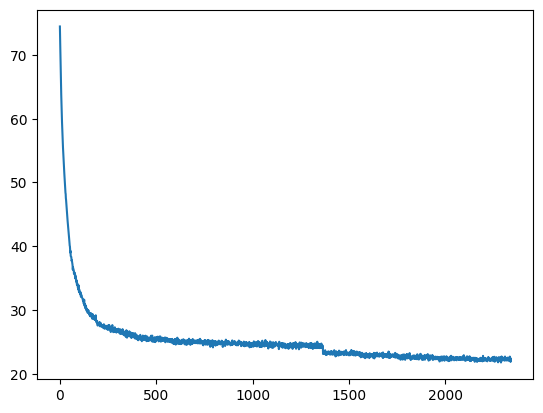

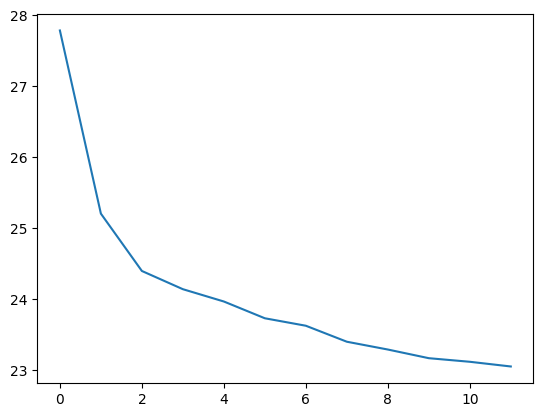

In [25]:
plt.plot(losses)
plt.show()
plt.plot(test_losses)
plt.show()

# Retrieve nearest neighbor in the training set using test set data

In [45]:
def log_result(result):
    id, caption, url, similarity = result["id"], result["caption"], result["url"], result["similarity"]
    print(f"id: {id}")
    print(f"caption: {caption}")
    print(f"url: {url}")
    print(f"similarity: {similarity}")
    display(Image(url=url, unconfined=True))

client = ClipClient(
    url="https://knn.laion.ai/knn-service",
    indice_name="laion5B-L-14",
    aesthetic_score=9,
    aesthetic_weight=0.5,
    modality=Modality.IMAGE,
    num_images=10,
)

Original Image (test set)


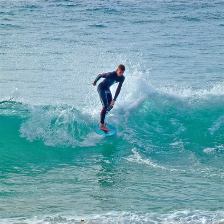

clip_l5b torch.Size([768])
id: 4406971844
caption: Jugar al frisbee en la playa
url: https://cdn.intermundial.es/blog/wp-content/uploads/2015/06/FRISBEE-EN-PLAYA.jpg
similarity: 0.5284299850463867


id: 2965276603
caption: Attractive man playing frisby on beach in summer Royalty Free Stock Image
url: https://thumbs.dreamstime.com/t/attractive-man-playing-frisby-beach-summer-sport-fitness-jump-33011186.jpg
similarity: 0.5244674682617188


IndexError: list index out of range

In [46]:
ii=2
# # all_indices = np.unique(train_73k_images) #np.hstack((test_vox_indices[ii],train_vox_indices))
# test_image, test_voxel = None, None
with torch.no_grad(), torch.cuda.amp.autocast():
    # with torch.no_grad(), torch.cuda.amp.autocast(): 
    #         for test_i, (behav, past_behav, future_behav, old_behav) in enumerate(test_dl):  
    #             # all test samples should be loaded per batch such that test_i should never exceed 0
    #             assert len(behav) == num_test
                
    #             ## Average same-image repeats ##
    #             if test_image is None:
    #                 voxel = voxels[behav[:,0,5].cpu().long()]
    #                 image = behav[:,0,0].cpu().long()
                    
    #                 unique_image, sort_indices = torch.unique(image, return_inverse=True)
    #                 for im in unique_image:
    #                     locs = torch.where(im == image)[0]
    #                     if test_image is None:
    #                         test_image = images[im][None]
    #                         test_voxel = torch.mean(voxel[locs],axis=0)[None]
    #                     else:
    #                         test_image = torch.vstack((test_image, images[im][None]))
    #                         test_voxel = torch.vstack((test_voxel, torch.mean(voxel[locs],axis=0)[None]))
#     for batch in tqdm(range(0, 118287, 512)):
#         if batch==0:
#             clip_target = clip_model.embed_image(final_tensor[batch:batch+512]).cpu()
#             # clip_target = clip_model.embed_image(images[all_indices[batch:batch+512]]).cpu()
#         else:
#             target = clip_model.embed_image(final_tensor[batch:batch+512]).cpu()
#             # target = clip_model.embed_image(images[all_indices[batch:batch+512]]).cpu()
#             clip_target = torch.vstack((clip_target,target))
#     clip_target_norm = nn.functional.normalize(clip_target.flatten(1), dim=-1)

    voxel = test_voxel[[ii]].to(device)
    image = test_image[[ii]].to(device)

    print("Original Image (test set)")
    display(utils.torch_to_Image(image))
    
    clip_target = clip_model.embed_image(image).cpu()
    # clip_target_norm = torch.vstack((clip_target_norm, nn.functional.normalize(clip_target.flatten(1), dim=-1)))
    
    voxel_ridge = model.ridge(voxel)
    clip_voxels, _, _ = model.backbone(voxel_ridge)    
    clip_voxels_norm = nn.functional.normalize(clip_voxels, dim=-1)
    # clip_voxels_norm = nn.functional.normalize(clip_target, dim=-1)
    clip_l5b = clip_voxels_norm[0, 0, :] 
    print("clip_l5b", clip_l5b.shape)
    # print("clip_target_norm", clip_target_norm.shape)
    ret = client.query(embedding_input=clip_l5b.tolist())
    for i in range(5):
        log_result(ret[i])

In [26]:
import os
from PIL import Image
import torch
from torchvision import transforms
import re

def numerical_sort(file):
    # Extract the number from the filename
    number = int(re.search(r'img_t(\d+)', file).group(1))
    return number

def load_and_process_images(directory_path):
    # Check if the directory exists
    if not os.path.exists(directory_path):
        raise Exception(f"The directory does not exist: {directory_path}")

    # Get list of all files in the directory
    file_list = os.listdir(directory_path)

    # Filter out non-image files
    image_files = [file for file in file_list if file.lower().endswith('.jpg')]
    sorted_image_files = sorted(image_files, key=numerical_sort)
    # Define a transformation pipeline
    preprocess = transforms.Compose([
        transforms.Resize((224, 224)),  # Resizing the image
        transforms.ToTensor(),  # Converting to tensor
    ])

    # List to hold the tensors
    tensor_list = []

    # Process each image
    for i in range(50000):
    # for i in range(len(sorted_image_files)):
        # Load the image
        with Image.open(os.path.join(directory_path, sorted_image_files[i])).convert("RGB") as img:  # Ensure RGB format
            # Apply the transformations and add to list
            tensor = preprocess(img)
            tensor_list.append(tensor)

    # Stack the individual tensors into a single tensor
    stacked_tensor = torch.stack(tensor_list)

    # Check the shape of the tensor
    print(f"Stacked Tensor Shape: {stacked_tensor.shape}")

    return stacked_tensor

# Replace with your actual directory path
directory_path = '/fsx/proj-fmri/shared/controlNetData/target/'
final_tensor = load_and_process_images(directory_path)


Stacked Tensor Shape: torch.Size([118287, 3, 224, 224])


In [ ]:
annots = np.load("/fsx/proj-fmri/shared/mindeyev2_dataset/COCO_73k_annots_curated.npy")

In [28]:
all_indices = np.unique(train_73k_images)
images.shape

torch.Size([73000, 3, 224, 224])

In [34]:
final_tensor[513:1024].shape

torch.Size([511, 3, 512, 512])

In [35]:
test_image.shape

torch.Size([982, 3, 224, 224])

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 232/232 [28:31<00:00,  7.38s/it]


Original Image (test set)


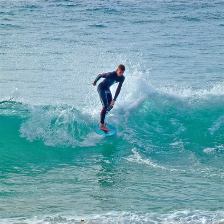

clip_voxels_norm torch.Size([1, 197376])
clip_target_norm torch.Size([118287, 197376])


In [29]:
ii=2
all_indices = np.unique(train_73k_images) #np.hstack((test_vox_indices[ii],train_vox_indices))
with torch.no_grad(), torch.cuda.amp.autocast():
    for batch in tqdm(range(0, 118287, 512)):
        if batch==0:
            clip_target = clip_model.embed_image(final_tensor[batch:batch+512]).cpu()
            # clip_target = clip_model.embed_image(images[all_indices[batch:batch+512]]).cpu()
        else:
            target = clip_model.embed_image(final_tensor[batch:batch+512]).cpu()
            # target = clip_model.embed_image(images[all_indices[batch:batch+512]]).cpu()
            clip_target = torch.vstack((clip_target,target))
    clip_target_norm = nn.functional.normalize(clip_target.flatten(1), dim=-1)

    voxel = test_voxel[[ii]].to(device)
    image = test_image[[ii]].to(device)

    print("Original Image (test set)")
    display(utils.torch_to_Image(image))
    
    clip_target = clip_model.embed_image(image).cpu()
    # clip_target_norm = torch.vstack((clip_target_norm, nn.functional.normalize(clip_target.flatten(1), dim=-1)))
    
    voxel_ridge = model.ridge(voxel)
    clip_voxels, _, _ = model.backbone(voxel_ridge)    
    clip_voxels_norm = nn.functional.normalize(clip_voxels.flatten(1), dim=-1)
    clip_voxels_norm = nn.functional.normalize(clip_target.flatten(1), dim=-1)

    print("clip_voxels_norm", clip_voxels_norm.shape)
    print("clip_target_norm", clip_target_norm.shape)
    


In [30]:
a1 = utils.batchwise_cosine_similarity(clip_voxels_norm.cpu(), clip_target_norm).flatten()
a1.shape

torch.Size([118287])

In [31]:
sortt = torch.argsort(utils.batchwise_cosine_similarity(clip_voxels_norm.cpu(), 
                                                            clip_target_norm).flatten()).flip(0)

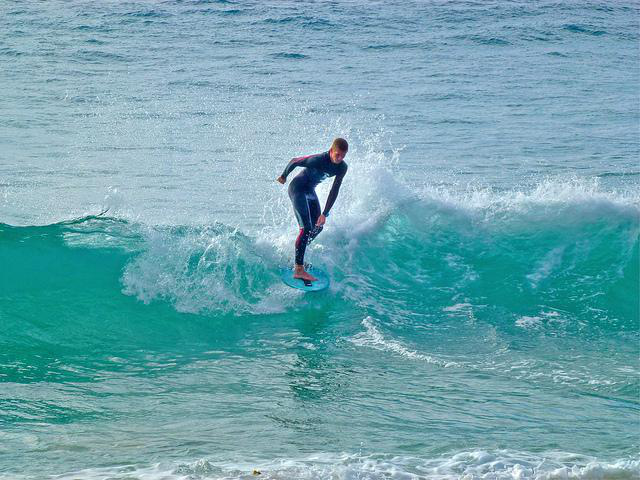

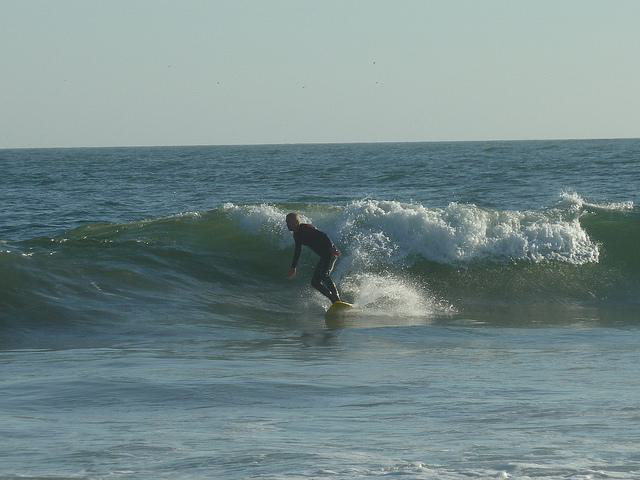

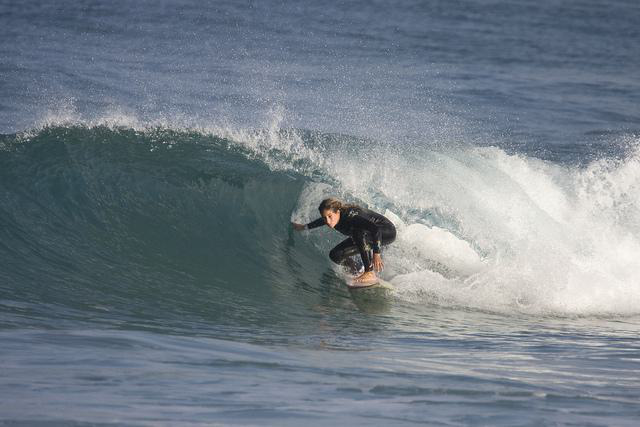

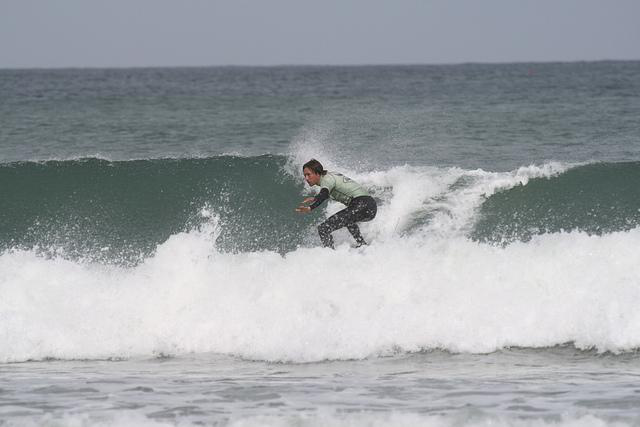

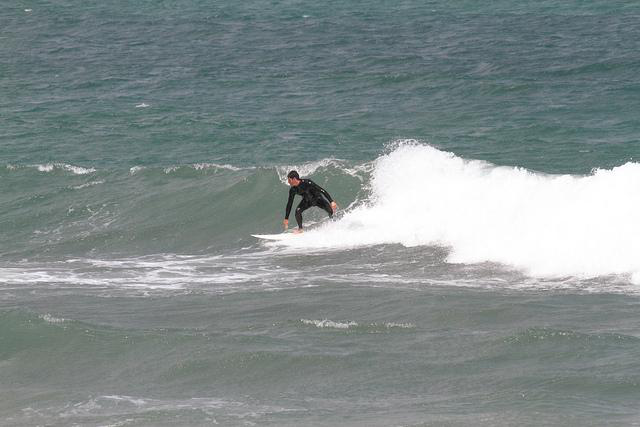


=====
predicted_caption:
 A person in a wetsuit surfing on a turquoise wave.


In [38]:
# print(sortt)
# picks = final_tensor[sortt[:5]]
import pickle
for i in range(5):
    img_dir = os.path.join(directory_path, f"img_t{sortt[i] + 1}.jpg")
    img = Image.open(img_dir)
    img.show()
    
    if i == 0:
        with open("/fsx/proj-fmri/shared/controlNetData/data_full.pkl", 'rb') as f:
            data = pickle.load(f)
            predicted_caption = utils.find_prompt_by_image_number(sortt[i] + 1, data)

# # Now you can print the data or do whatever you want with it
# print(data[591752])
        
# print(picks)
# for ip,p in enumerate(picks):
#     display(utils.torch_to_Image(images[[p]]))
#         # print(utils.select_annotations([annots[int(p)]]))
#     # if ip==0: 
#     #     predicted_caption = utils.select_annotations([annots[int(p)]])[0]
#     #     print("\nNearest neighbors in training set:\n", predicted_caption)

print("\n=====\npredicted_caption:\n", predicted_caption)

# Feed into Stable Diffusion XL for reconstructions

In [39]:
from diffusers import StableDiffusionXLPipeline
pipe = StableDiffusionXLPipeline.from_pretrained(
    "/fsx/proj-fmri/shared/cache/models--stabilityai--stable-diffusion-xl-base-1.0/snapshots/f898a3e026e802f68796b95e9702464bac78d76f", torch_dtype=torch.float16, variant="fp16", use_safetensors=True
)
pipe.to("cuda")
pass

Loading pipeline components...: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:05<00:00,  1.22it/s]


In [40]:
prompt = predicted_caption
recon = pipe(prompt=prompt).images[0]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:06<00:00,  8.06it/s]


Seen image


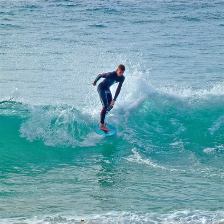

Reconstruction


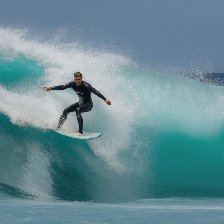

In [41]:
print("Seen image")
display(utils.torch_to_Image(image))

print("Reconstruction")
utils.torch_to_Image(utils.resize(transforms.ToTensor()(recon),224))